In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from mlxtend.preprocessing import minmax_scaling
import plotly.express as px
import datetime as dt

In [425]:
import warnings 
warnings.filterwarnings('ignore')

# Introduction 

**Here I will be analyzing the data of police shootings that happened in the US from 2015 to 2017**

# Loading The Data

In [5]:
shooting_data = pd.read_csv('./shootings.csv', sep=',', index_col=0)
shooting_data.head(5)

,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
id,,,,,,,,,,,,,
3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


# Data Cleaning

In [246]:
shooting_data.duplicated().any()

True

In [247]:
missing_values_count = shooting_data.isnull().sum()
missing_values_count  

name                        19
date                         0
manner_of_death              0
armed                        6
age                         43
gender                       1
race                       103
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                        36
body_camera                  0
dtype: int64

In [6]:
shooting_data = shooting_data.dropna()

# Treating the outliers

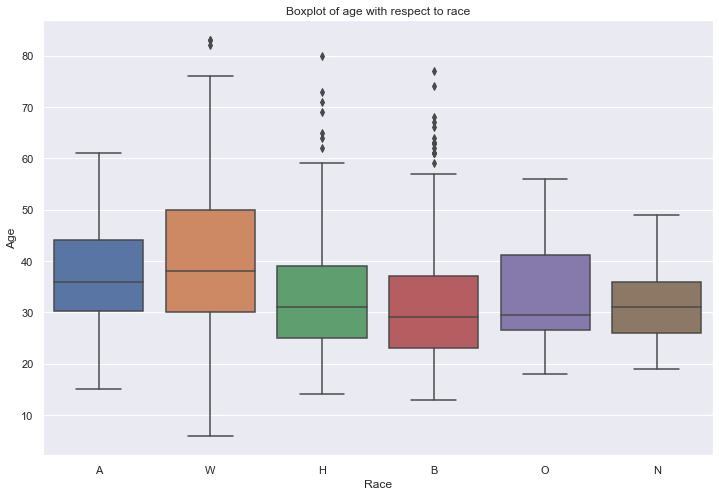

In [428]:
sb.boxplot(x='race', y='age', data=shooting_data)
plt.xlabel("Race")
plt.ylabel("Age")
plt.title("Boxplot of age with respect to race")
plt.show()

**What's interesting here is that we can see most of the people killed  not in the normal age group were black or hispanic**

## Number of people killed by race

In [429]:
race_killed = shooting_data.race.value_counts()
race_killed

W    1022
B     523
H     355
A      32
O      28
N      26
Name: race, dtype: int64

**Here looking at the numbers it may seem that it's far more likely for a white person to get killed by the police, though it doesn't tell us the whole story since there is quite a large difference in the population so we will have to take a deeper look**

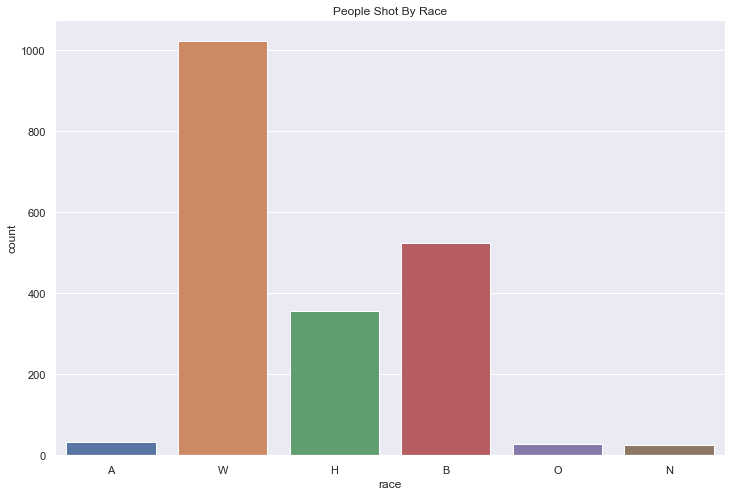

In [433]:
sb.countplot(data = shooting_data, x = 'race')
plt.title('People Shot By Race')
plt.show()

## Taking the percentage of people killed

In [251]:
race_killed_percentage = shooting_data.race.value_counts(normalize = True)
race_killed_percentage.round(2)

W    0.51
B    0.26
H    0.18
A    0.02
O    0.01
N    0.01
Name: race, dtype: float64

## Percentages in a pie chart

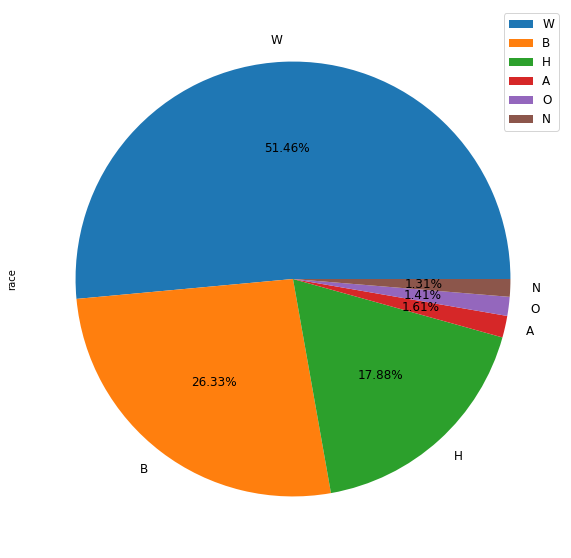

In [252]:
shooting_data['race'].value_counts().plot.pie(textprops={'fontsize': 12}, autopct='%.2f%%', figsize=(15, 10))
plt.rcParams['legend.fontsize'] = 12
plt.legend(loc = 'upper right')
plt.show()

## Killings in relation to the population of each race

**Here I'm taking the population of races in 2021 and dividing the people killed of each race by that number there might be a better way to do this though I am not familiar with it**

In [253]:
killings_proportional_to_pop = {'White' : [1022/(332997863 * 0.603)], 'Black' : [523/(332997863 * 0.134)], 'Hispanic' : [355/(332997863 * 0.185)], 'Asian' : [32/(332997863 * 0.059)], 'Native American' : [26/(332997863 * 0.016)]}

In [473]:
proportions = pd.DataFrame(data=killings_proportional_to_pop)

# Taking people killed by the million and plotting it

In [255]:
for key in proportions:
    proportions[key] *= 1000000
proportions.round(2)

,White,Black,Hispanic,Asian,Native American
0,5.09,11.72,5.76,1.63,4.88


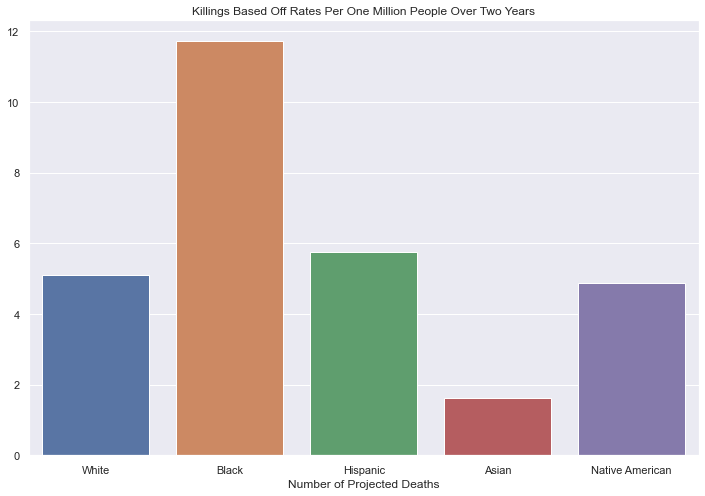

In [460]:
ax = sb.barplot(data=proportions,)
plt.xlabel("Number of Projected Deaths")
plt.title("Killings Based Off Rates Per One Million People Over Two Years")
plt.show()

**Now we are getting closer to uncovering a bias in police shootings in the US though there is still one more thing to check if the person of that race was threatening the officers life**

In [456]:
black_attack = ((shooting_data['race'] == 'B') & (shooting_data['threat_level'] == 'attack')).sum()
round((black_attack/522) * 100, 2)

67.62

In [458]:
white_attack = ((shooting_data['race'] == 'W') & (shooting_data['threat_level'] == 'attack')).sum()
round((white_attack/1022) * 100, 2)

67.22

In [461]:
hispanic_attack = ((shooting_data['race'] == 'H') & (shooting_data['threat_level'] == 'attack')).sum()
round((hispanic_attack/355) * 100, 2)

59.44

**Here from these numbers it can be seen that black people are more likely to be shot by the police since they attack them at pretty much the same rate as white people do**

# Taking a look at the year/month/day statistics

In [513]:
shooting_data["date"] = pd.to_datetime(shooting_data["date"])

In [525]:
shooting_data['year'] = shooting_data.date.dt.year

In [528]:
shooting_data['day'] = shooting_data.date.dt.day

In [516]:
shooting_data['month'] = shooting_data.date.dt.month

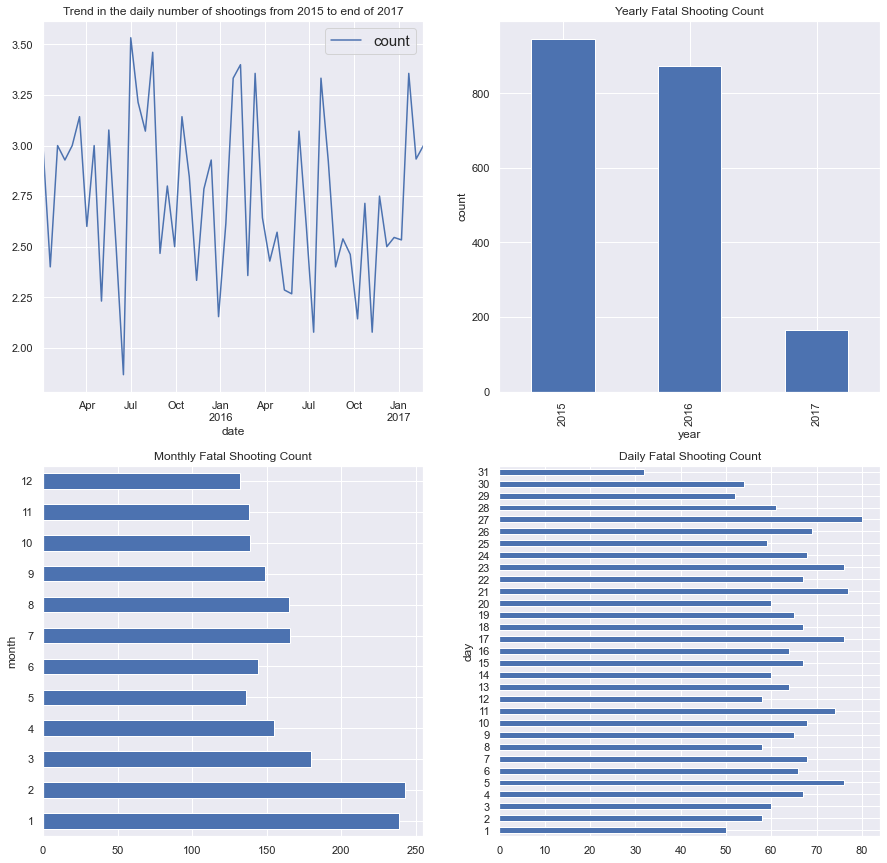

In [544]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,squeeze=True, figsize=(15,15))

bydate = shooting_data[['date','name']].groupby('date').count().sort_values(by='date')
bydate.rename(columns={"name":'count'}, inplace=True)
bydate.resample('15D').mean().plot(
    title=('Trend in the daily number of shootings from 2015 to end of 2017'),ax=ax1)

shooting_data.groupby('year').count()['name'].plot(
    kind='bar',  ylabel=('count'),
    title=('Yearly Fatal Shooting Count'), ax=ax2)
                            

shooting_data.groupby('month').count()['name'].plot(
    kind='barh', ylabel=('count'),
    title=('Monthly Fatal Shooting Count'), ax=ax3)


shooting_data.groupby('day').count()['name'].plot(
    kind='barh', ylabel=('count'),
    title=('Daily Fatal Shooting Count'), ax=ax4)
plt.show()

# Checking to see if there were any minors killed

In [545]:
(shooting_data['age'] < 18).any()

True

**As we can see there was, hopefully it's not too much**

In [484]:
(shooting_data['age'] < 18).value_counts()

False    1948
True       38
Name: age, dtype: int64

In [485]:
(shooting_data['age'] < 18).value_counts(normalize = True)

False    0.980866
True     0.019134
Name: age, dtype: float64

**As we can see about 2% were little children which is super sad to see**

In [486]:
most_violent_states = shooting_data.state.value_counts(ascending = False).head(10)
most_violent_states

CA    320
TX    183
FL    121
AZ     89
NC     63
CO     59
OH     59
GA     56
OK     54
MO     50
Name: state, dtype: int64

# Most violent states and cities

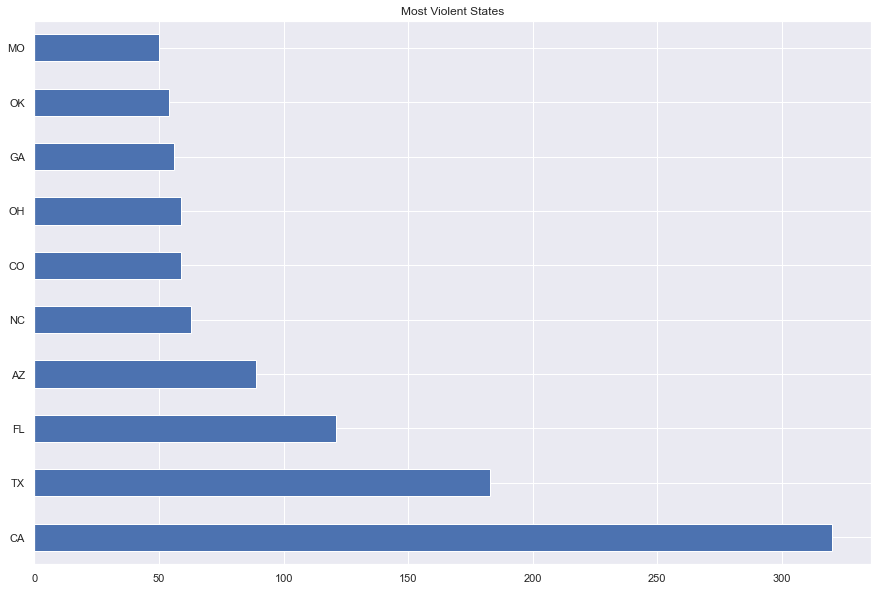

In [549]:
ax = most_violent_states.plot.barh(figsize = (15,10))
plt.title('Most Violent States')
plt.show()

**It might seem that there are some really violent states compared to others but the explanation for that is that the population of the state is much larger compared to others**

In [477]:
most_violent_cities = shooting_data.city.value_counts(ascending = False).head(10)
most_violent_cities

Los Angeles     30
Houston         22
Phoenix         22
Chicago         20
Austin          16
Las Vegas       15
Miami           15
Columbus        14
San Antonio     14
Indianapolis    13
Name: city, dtype: int64

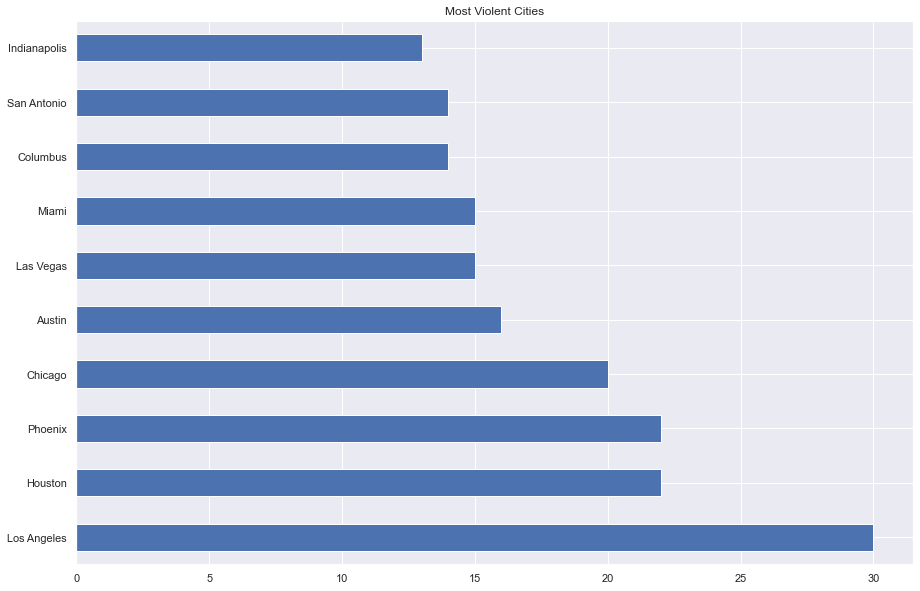

In [550]:
ax = most_violent_cities.plot.barh(figsize = (15,10))
plt.title('Most Violent Cities')
plt.show()

**The same thought process works for the cities also**

# Taking a look at the manner of death of the victims

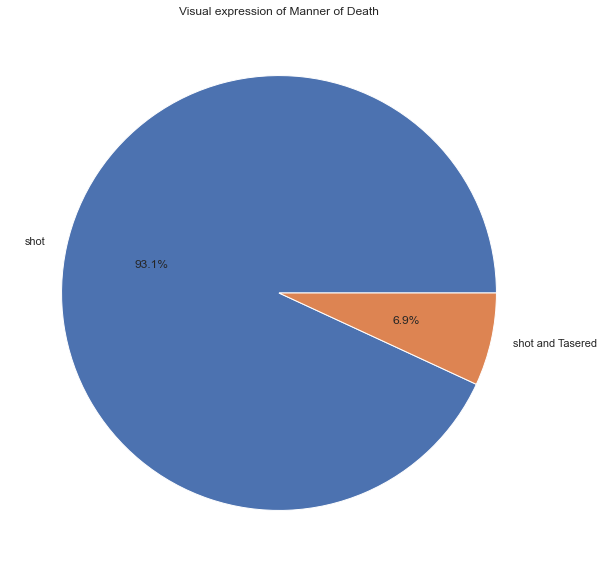

In [547]:
plt.figure(0, figsize=(15,10))
shooting_data.manner_of_death.value_counts().plot.pie(
    title=('Visual expression of Manner of Death'),autopct="%.1f%%",ylabel=(''))
plt.show()

# Gender plot

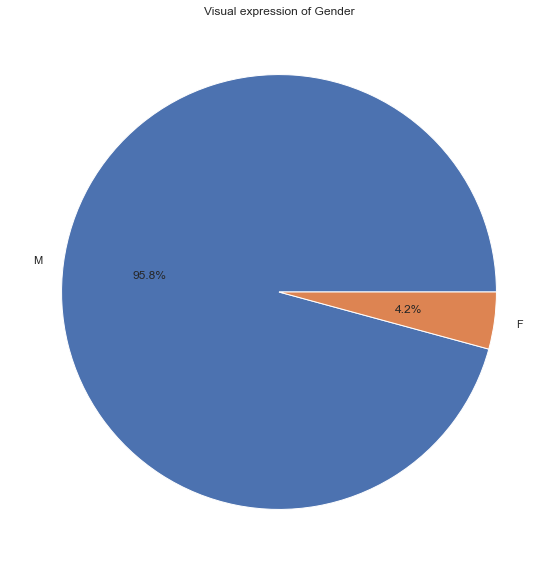

In [435]:
plt.figure(1, figsize=(15,10))
shooting_data.gender.value_counts().plot.pie(
    title=('Visual expression of Gender'),autopct="%.1f%%" ,
    ylabel=(''))
plt.show()

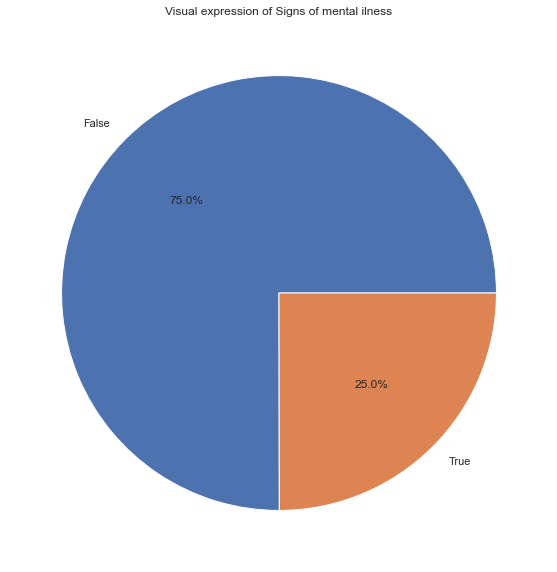

In [548]:
plt.figure(2, figsize=(15,10))
shooting_data.signs_of_mental_illness.value_counts().plot.pie(
    title=('Visual expression of Signs of mental ilness'),autopct="%.1f%%",
    ylabel=(''))
plt.show()

# Taking a look at the threat level to the officers

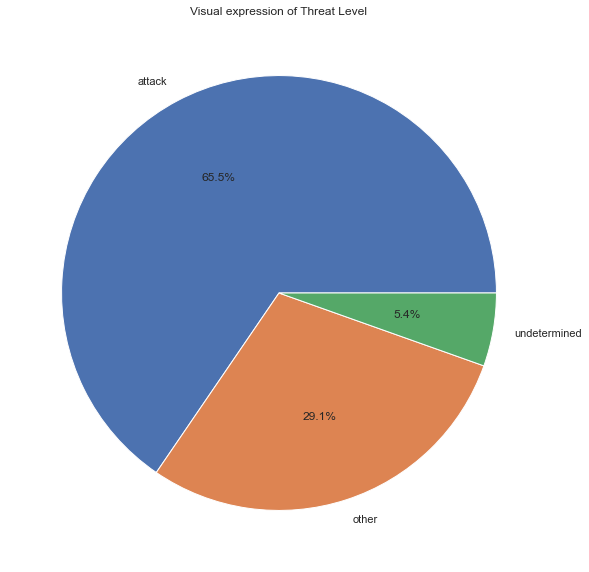

In [551]:
plt.figure(3, figsize=(15,10))
shooting_data.threat_level.value_counts().plot.pie(
    title=('Visual expression of Threat Level'),autopct="%.1f%%", ylabel=(''))
plt.show()

# Pie chart of people fleeing

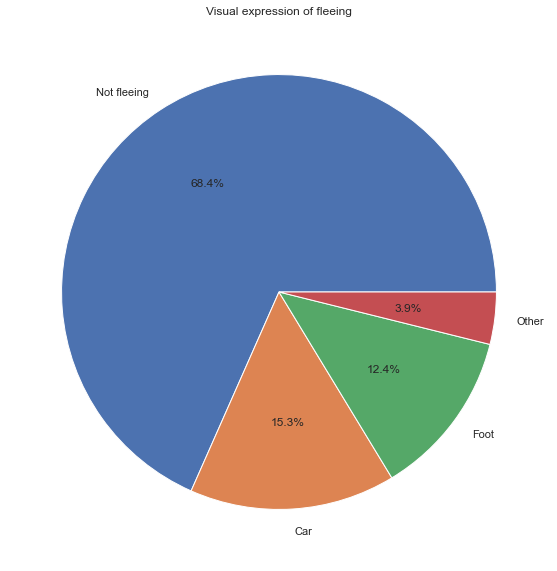

In [552]:
plt.figure(4, figsize=(15,10))
shooting_data.flee.value_counts().plot.pie(
    title=('Visual expression of fleeing'),autopct="%.1f%%",
    ylabel=(''))
plt.show()

# Police officers using body camera and not using it

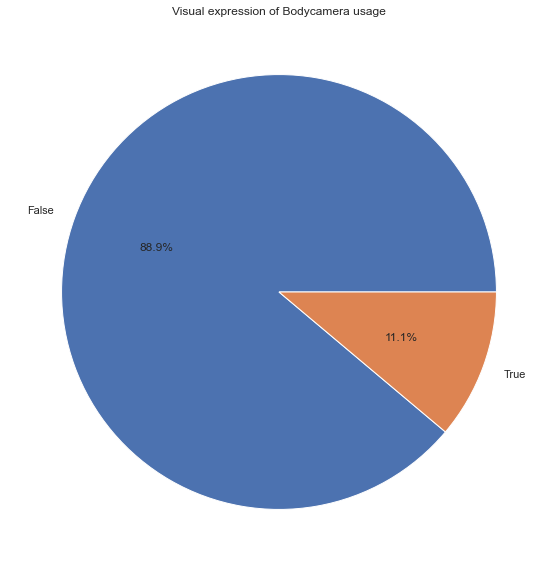

In [553]:
plt.figure(5, figsize=(15,10))
shooting_data.body_camera.value_counts().plot.pie(
    title=('Visual expression of Bodycamera usage'),autopct="%.1f%%",
    ylabel=(''))

plt.show()

# Any relation between signs of mental ilness and attacking officers ?

In [11]:
mental_attack = ((shooting_data['signs_of_mental_illness'] == True) & (shooting_data['threat_level'] == 'attack')).sum()

In [566]:
shooting_data.threat_level.value_counts(normalize = True)

attack          0.654582
other           0.291037
undetermined    0.054381
Name: threat_level, dtype: float64

In [13]:
all_attacks = (shooting_data.threat_level == 'attack').sum()

In [15]:
round(mental_attack/all_attacks, 2)

0.24

In [557]:
shooting_data.armed.unique()

array(['gun', 'unarmed', 'toy weapon', 'nail gun', 'knife', 'vehicle',
       'shovel', 'hammer', 'hatchet', 'undetermined', 'sword', 'machete',
       'box cutter', 'metal object', 'screwdriver', 'lawn mower blade',
       'flagpole', 'guns and explosives', 'cordless drill', 'crossbow',
       'metal pole', 'Taser', 'metal pipe', 'metal hand tool',
       'blunt object', 'metal stick', 'sharp object', 'meat cleaver', nan,
       'carjack', 'chain', "contractor's level", 'unknown weapon',
       'stapler', 'beer bottle', 'bean-bag gun',
       'baseball bat and fireplace poker', 'straight edge razor',
       'gun and knife', 'ax', 'brick', 'baseball bat', 'hand torch',
       'chain saw', 'garden tool', 'scissors', 'pole', 'pick-axe',
       'flashlight', 'baton', 'spear', 'pitchfork', 'hatchet and gun',
       'rock', 'piece of wood', 'bayonet', 'pipe', 'glass shard',
       'motorcycle', 'metal rake', 'crowbar', 'oar', 'machete and gun',
       'tire iron', 'pole and knife'], dtype=o

**Favorite weapons of mine must be rock, piece of wood and a spear shows the progression of the modern man**

In [318]:
shooting_data.armed.value_counts(ascending = False)
frequent_weapons = shooting_data.armed.value_counts(ascending = False).head(10)
frequent_weapons

gun               1094
knife              290
unarmed            151
vehicle            128
toy weapon          90
undetermined        90
machete             15
unknown weapon      11
sword                8
hammer               7
Name: armed, dtype: int64

In [560]:
shooting_data.armed.value_counts(ascending = False, normalize = True)

gun                    0.550856
knife                  0.146022
unarmed                0.076032
vehicle                0.064451
toy weapon             0.045317
                         ...   
hatchet and gun        0.000504
beer bottle            0.000504
straight edge razor    0.000504
cordless drill         0.000504
pick-axe               0.000504
Name: armed, Length: 61, dtype: float64

**As we can see 55% of the armed people had a gun a more interesting metric in this dataset would be too see what kind of gun they had assault rifle or pistol**

# Performing K-Means on data

In [261]:
# Encoding string data to numeric for clustering
X = pd.get_dummies(
    shooting_data.filter(
        [
            "manner_of_death",
            "signs_of_mental_illness",
            "armed",
            "race",
            "flee",
            "gender",
        ]
    )
)
X

,signs_of_mental_illness,manner_of_death_shot,manner_of_death_shot and Tasered,armed_Taser,armed_ax,armed_baseball bat,armed_baseball bat and fireplace poker,armed_baton,armed_bayonet,armed_bean-bag gun,...,race_H,race_N,race_O,race_W,flee_Car,flee_Foot,flee_Not fleeing,flee_Other,gender_F,gender_M
id,,,,,,,,,,,,,,,,,,,,,
3,True,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,False,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
5,False,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
8,True,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
9,False,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382,False,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
2378,True,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
2391,False,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1


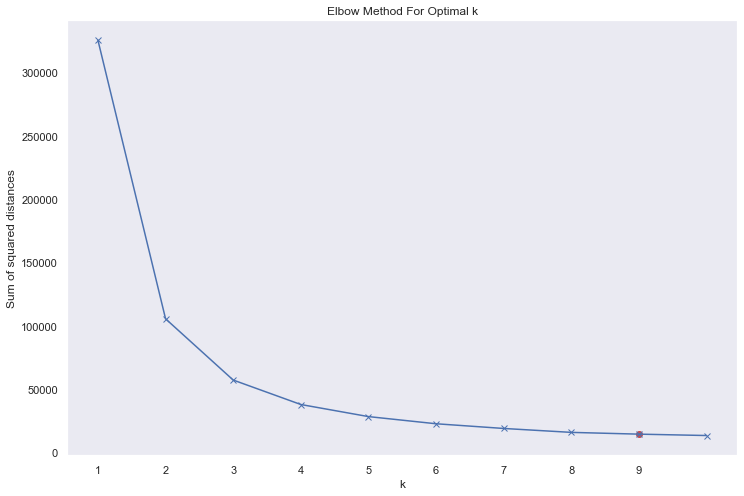

In [415]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)


# Plotting the sum of square distances by k to find optimal k
plt.grid()
plt.xticks(range(10))
plt.plot(K, Sum_of_squared_distances, "bx-")
plt.xlabel("k")
plt.ylabel("Sum of squared distances")
plt.title("Elbow Method For Optimal k")
plt.scatter(9, Sum_of_squared_distances[8], color="r")
plt.show()

# GeoMap of shootings

In [8]:
states = shooting_data.groupby('state').agg({'name':'count'}).reset_index().sort_values(by = ['name'], ascending = False)
states.head(10)

,state,name
4,CA,320
43,TX,183
9,FL,121
3,AZ,89
27,NC,63
35,OH,59
5,CO,59
10,GA,56
36,OK,54
24,MO,50


In [9]:
fig = px.choropleth(
   states,
    locations="state",
    color="name",
    hover_name="state",
    locationmode="USA-states",
)
fig.update_layout(
    title_text="Map Of Police Shootings In The US ",
    geo_scope="usa",
)
fig.show()

# Machine learning model to predict the race of the victim

In [380]:
# Separating and encoding data to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(shooting_data["race"])
X = pd.get_dummies(
    shooting_data.filter(
        [
            "manner_of_death",
            "signs_of_mental_illness",
            "armed",
            "flee",
            "threat_level",
            "state",
            "gender",
            "age",
            "city",
        ]
    )
)

In [471]:
# Splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [472]:
# Building a random forests classifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=369)
rfc.fit(X_train, y_train)
print(f"Model predicts with {round((rfc.score(X_test, y_test)*100), 2)}% accuracy")

Model predicts with 61.31% accuracy


In [416]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rfc.predict(X_test), target_names=le.classes_))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00         5
           B       0.59      0.39      0.47       101
           H       0.54      0.37      0.44        73
           N       0.00      0.00      0.00         7
           O       0.00      0.00      0.00         6
           W       0.64      0.86      0.73       206

    accuracy                           0.61       398
   macro avg       0.29      0.27      0.27       398
weighted avg       0.58      0.61      0.58       398

